In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [87]:
len(words)

32033

In [88]:
# buld the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [89]:
# build the dataset
block_size = 3 # context length
context = [0] * block_size
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append (rolling window)

X = torch.tensor(X)
Y = torch.tensor(Y)


In [90]:
C = torch.randn((27, 2)) # each one of 27 chars has a two dimensional embedding


In [91]:
# pytorch can embed based on putting the indexes of one array into another. It can even be a tensor:
C[X][0]

tensor([[ 0.0152, -0.3809],
        [ 0.0152, -0.3809],
        [ 0.0152, -0.3809]])

In [92]:
# C[X][0] will now have the values from C[0] because in X[0] we have the input values [0,0,0]
C[0]

tensor([ 0.0152, -0.3809])

In [93]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [94]:
# tanh layer
W1 = torch.randn((6, 100)) # we have 3x2 inputs = 6 inputs, and use 100 neurons
b1 = torch.randn(100)      # create a random bias for 100 neurons

# we need a 32x6 matrix to do matrix multiplication with W1 and b1 above
# torch.cat can concatenate dimensions
# torch.unbind removes a dimension
# torch.unbind(emb, 1)
torch.cat(torch.unbind(emb, 1), 1)

# a more efficient way to do this is using .view
emb.view(32, 6) # this automatically joins the last two dimensions

# now we can do the full matrix multiplication + bias
h = torch.tanh(emb.view(32, 6) @ W1 + b1)

# be aware that b1 only works because of broadcasting
#    32,   100
# b1 (1)   100 (will be moved to the right and prefilled with 1 on the first dimension)

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [ ]:
# final layer: probabilities with softmax
W2 = torch.randn(100, 27)  # 100 inputs, 27 neurons output for 27 characters that could come next
b2 = torch.randn(27)       # aligned to 27 neurons

logits = h @ W2 + b2

# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [ ]:
# what are the probabilities given by the network checked by the actual values Y?
prob[torch.arange(32), Y]

tensor([7.6332e-08, 3.2518e-07, 2.4698e-07, 2.5882e-07, 6.0520e-11, 1.3723e-04,
        1.7272e-04, 1.5497e-14, 3.9339e-15, 2.4025e-11, 6.7298e-14, 6.4589e-06,
        9.2989e-04, 3.4884e-05, 6.1591e-03, 8.2429e-15, 1.8004e-13, 1.0577e-07,
        3.4525e-08, 3.7356e-02, 2.1025e-02, 7.9648e-11, 2.3077e-14, 1.9419e-09,
        8.9234e-12, 3.3073e-01, 1.8723e-03, 6.7536e-03, 5.3595e-07, 1.3195e-07,
        9.1132e-11, 5.4150e-06])

In [ ]:
# neg log likelihood
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.7831)

In [95]:
# full example in one go
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [158]:
g = torch.Generator().manual_seed(2147483647)
# input layer
C = torch.randn((27, 2), generator=g)
# tanh layer
W1 = torch.randn((6, 100), generator=g) # we have 3x2 inputs = 6 inputs, and use 100 neurons
b1 = torch.randn(100, generator=g)      # create a random bias for 100 neurons
# final layer: probabilities with softmax
W2 = torch.randn(100, 27, generator=g)  # 100 inputs, 27 neurons output for 27 characters that could come next
b2 = torch.randn(27, generator=g)       # aligned to 27 neurons
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # numbers of parameters in total

3481

In [155]:
lre = torch.linspace(-3, 0, 1000) # creates 1000 numbers between 0.001-1
lrs = 10**lre                     # spaced exponentionally
lrs                               # learning rate steps

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [170]:
lri = []
lossi = []

for i in range(10000):

    # only train on a subset of the data (e.g. 32 random examples)
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # embeds X (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # contents of neurons layer 1 (32, 100)
    logits = h @ W2 + b2                      # contents of neuron layer 2 (32, 27)

    # this full block can be done by pytorch
    #counts = logits.exp()                     # softmax
    #prob = counts / counts.sum(1, keepdim=True)
    #loss = -prob[torch.arange(32), Y].log().mean() # neg. log likelihood
    loss = F.cross_entropy(logits, Y[ix]) # this is better, more efficient, and has less side-effects (e.g. handles extreme values)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    # lr = lrs[i]
    lr = 0.01 # 1.0 --> learning rate decay to get closer to best value
    for p in parameters:
        p.data += -lr * p.grad # play with the learning rate to make sure it constantly decreases without jumps

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

# loss of this iteration
print(loss.item())


2.2992496490478516


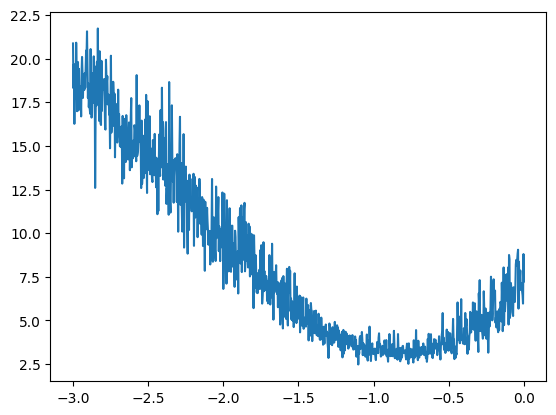

In [157]:
# plotting the learning rate + losses
# the value that is lowest is a good learning rate, here about -1
plt.plot(lri, lossi)

In [171]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
# loss of full dataset
loss

tensor(2.3259, grad_fn=<NllLossBackward0>)

In [ ]:
# the main problem we have now, is that the model knows all data
# in the end it will just "remember" everything (then the loss is perfect) --> overfitting
# we can split the training data and test data to verify without overfitting
# 80% - training split
# 10% - validation/dev split -> use this to try differnt things with hyper-parameters (like No. of layers, sizes and so on)
# 10% - test split
# see the next notebook for this